## PCoA figures
- Transforming data
- Permanova stats
- PCoA plots
- BioEnv analysis

In [ ]:
# Load libraries
library(vegan)
library(ape)
library(ggplot2)
library(RColorBrewer)
library(dplyr)
library(tidyr)
library(devtools)
library(ggConvexHull)
library(tidyverse)
library(broom)

In [12]:
# Load the files required and transpose
otu <- read.table("../data/220810_covtab_norm.csv", 
              sep=",", header=T, row.names=1)

# Sub select based on header names
#otu <- otu %>% dplyr::select(contains("BMLB",ignore.case = TRUE))
otu <- otu %>% dplyr::select(matches("HC|BMLF|BMLS|GP",ignore.case = TRUE))

# transpose data
otu <- t(otu)

# remove rows with all zeros
otu <- otu[apply(otu[,-1], 1, function(x) !all(x==0)),]
                 
# open metadata file
cat_meta <- read.csv("../data/220426_metadata_correct.csv", sep=',', header=1, row.names=1)
                 

In [15]:
# transform the data
otu.xform <- decostand(otu, method="hellinger")

# create dissimilarity matrix for the vOTU table with bray or jaccard method
otu.dist <- as.matrix(vegdist(otu.xform, method='jaccard'))

# nmds
otu.nmds <- metaMDS(otu.dist)
otu.nmds$stress

# R will not automatically bind datapoints with the same name, but randomly bind them
# therefore order cat data with this
cat_meta.ordered <- cat_meta[match(row.names(otu.nmds$points), row.names(cat_meta)),]   

# perform pcoa with ape package pcoa
pcoa <- pcoa(as.dist(otu.dist))

# make a dataframe named axes, put pcoa values in there
axes <- as.data.frame(pcoa$vectors)

# Give df extra column with the rownames in it 
axes$SampleID <- rownames(axes)

# put the metadata in the same dataframe, with correct sample name
cat_meta.ordered$SampleID <- rownames(cat_meta.ordered)

cat_meta$SampleID <- rownames(cat_meta)


# calculate the eigenvalues for each pcoa axes 
eigval <- round(pcoa$values$Relative_eig * 100, digits = 2)

# merge those dfs
axes <- merge(cat_meta.ordered, axes, by.x = "SampleID", by.y = "SampleID")



Run 0 stress 0.1282726 
Run 1 stress 0.1333279 
Run 2 stress 0.1219833 
... New best solution
... Procrustes: rmse 0.07321393  max resid 0.2373512 
Run 3 stress 0.128268 
Run 4 stress 0.1219565 
... New best solution
... Procrustes: rmse 0.002531129  max resid 0.01285539 
Run 5 stress 0.1224376 
... Procrustes: rmse 0.06603908  max resid 0.2538482 
Run 6 stress 0.1219058 
... New best solution
... Procrustes: rmse 0.02866841  max resid 0.09555682 
Run 7 stress 0.1285477 
Run 8 stress 0.1282866 
Run 9 stress 0.1228425 
Run 10 stress 0.1269859 
Run 11 stress 0.1284802 
Run 12 stress 0.127722 
Run 13 stress 0.1219058 
... New best solution
... Procrustes: rmse 7.058719e-05  max resid 0.0001826668 
... Similar to previous best
Run 14 stress 0.1232772 
Run 15 stress 0.121951 
... Procrustes: rmse 0.002016355  max resid 0.010493 
Run 16 stress 0.1232343 
Run 17 stress 0.1221348 
... Procrustes: rmse 0.004351665  max resid 0.0208188 
Run 18 stress 0.1224288 
Run 19 stress 0.1282755 
Run 20 st

[1] 0.1219058

In [16]:
# Put those eigenvalues in a df so they easy to get to. 
eigval <- data.frame( PC = 1:length(eigval), Eigval = eigval)
# head(eigval) # see top eigenvalues
eigval[[1,2]] # see first axes percentage
eigval[[2,2]] # second axes
eigval[[3,2]] # third axes
eigval[[4,2]] # fourth axes


[1] 8.21

[1] 7.44

[1] 6.09

[1] 4.72

## Statistical tests
- Permanova to see what has effect on viral community composition

In [28]:
# permanova
pmanova2 = adonis2(as.dist(otu.dist) ~  plot_detail * perc_moisture, data = cat_meta.ordered)
pmanova2

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
plot_detail,4,4.9756108,0.23718034,3.298857,0.001
perc_moisture,1,0.6156942,0.02934927,1.632835,0.003
plot_detail:perc_moisture,4,2.1893931,0.10436528,1.451580,0.001
Residual,35,13.1974777,0.62910511,NA,NA
Total,44,20.9781759,1.00000000,NA,NA


In [31]:
# Permanova for all soil biochemical measurements
pmanova2 = adonis2(as.dist(otu.dist) ~  Sodium_ppm_Na + soil_ph + perc_moisture + org_matter + 
                   Nitrate_N_ppm_N + Olsen_P_ppm_P + Potassium_ppm_K + Sulfate_S_ppm_S + Zinc_ppm_Zn 
                   + Iron_ppm_Fe + Manganese_ppm_Mn + Copper_ppm_Cu + Calcium_ppm_Ca + Magnesium_ppm_Mg + 
                   Sodium_ppm_Na + CEC_Sum_of_Cations_me_100g, data = cat_meta.ordered)
pmanova2

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sodium_ppm_Na,1,0.6306898,0.03006409,1.4389229,0.011
soil_ph,1,0.6780877,0.03232348,1.5470615,0.005
perc_moisture,1,1.0976993,0.05232577,2.5044080,0.001
org_matter,1,0.3471256,0.01654698,0.7919692,0.965
Nitrate_N_ppm_N,1,0.5535804,0.02638840,1.2629973,0.046
Olsen_P_ppm_P,1,0.5733753,0.02733199,1.3081593,0.031
Potassium_ppm_K,1,0.7370420,0.03513375,1.6815660,0.003
Sulfate_S_ppm_S,1,0.5799963,0.02764760,1.3232652,0.031
Zinc_ppm_Zn,1,0.3838450,0.01829735,0.8757449,0.833


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



null device 
          1

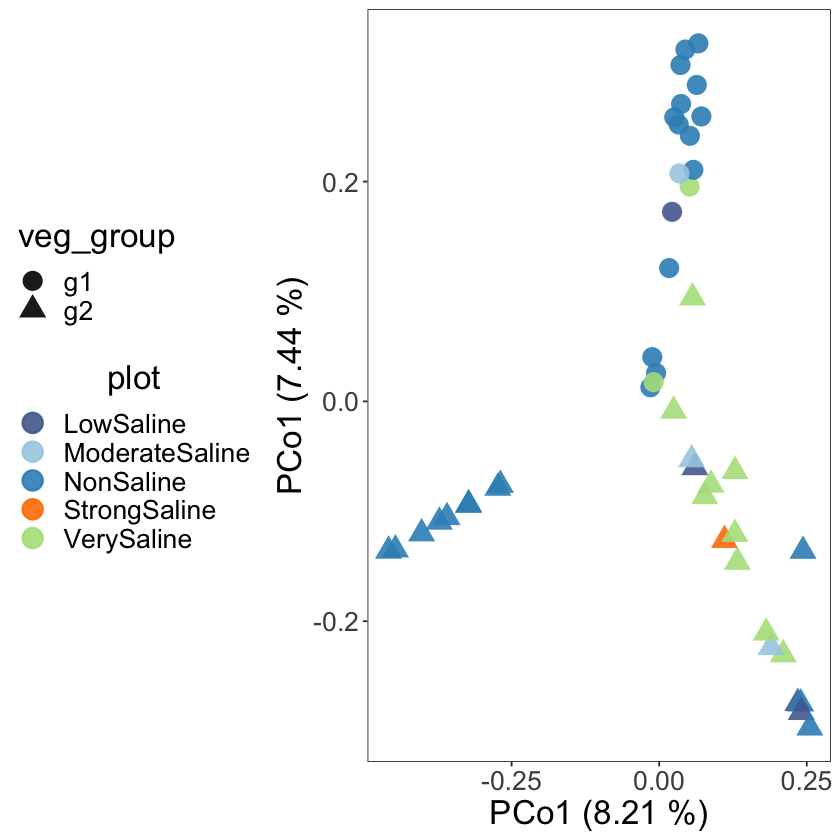

In [18]:
# Pcoa that is colored for categorial metadata

# write to pdf
#pdf("../plots/221003_PCOA_a12.pdf")

# set plot
p <- ggplot(axes, aes(Axis.1, Axis.2), width = 7, height = 3) 

# set color of the points as the factor depth, shape as year, set size and see-throughness
p + geom_point(aes(colour=as.character(wardlab_cat), shape=veg_group), size = 5,alpha=0.9, stroke=1) +
#p + geom_point(aes(colour=as.character(bulk_rhizo)), size = 6,alpha=0.9, stroke=1) +
 
  # set text for the axis lables
  xlab(paste("PCo1 (", eigval$Eigval[1], " %)", sep = "")) +  # or somthing else
  ylab(paste("PCo1 (", eigval$Eigval[2], " %)", sep = "")) +
  

  # dotted lines through the plot
  #geom_vline(xintercept = 0, linetype = 2) +
  #geom_hline(yintercept = 0, linetype = 2) +
  
  # set the colors of the points with the colorbrewer pallet
  scale_color_brewer(name = "plot", palette = "Paired") +

  # you can set colors manually by this: 
  scale_color_manual(name = 'plot', values = c("#536c9b", "#a6cee3", "#3690c0", "#ff7f00", "#b2df8a", '#33a02c', '#ec5c5d'))  +

  # set shapes of the points
  #scale_shape_manual(name = "Plot", values=c(16,17,15,18)) +

  # tell where the legend has to be
  guides(color = guide_legend(title.position = "top", title.hjust = 0.5)) +
  theme_bw() +
  
  # set text size for whole graph. set the background color (white with no lines)
  theme(text = element_text(size = 20), panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
        legend.position = "left") 
dev.off()

null device 
          1

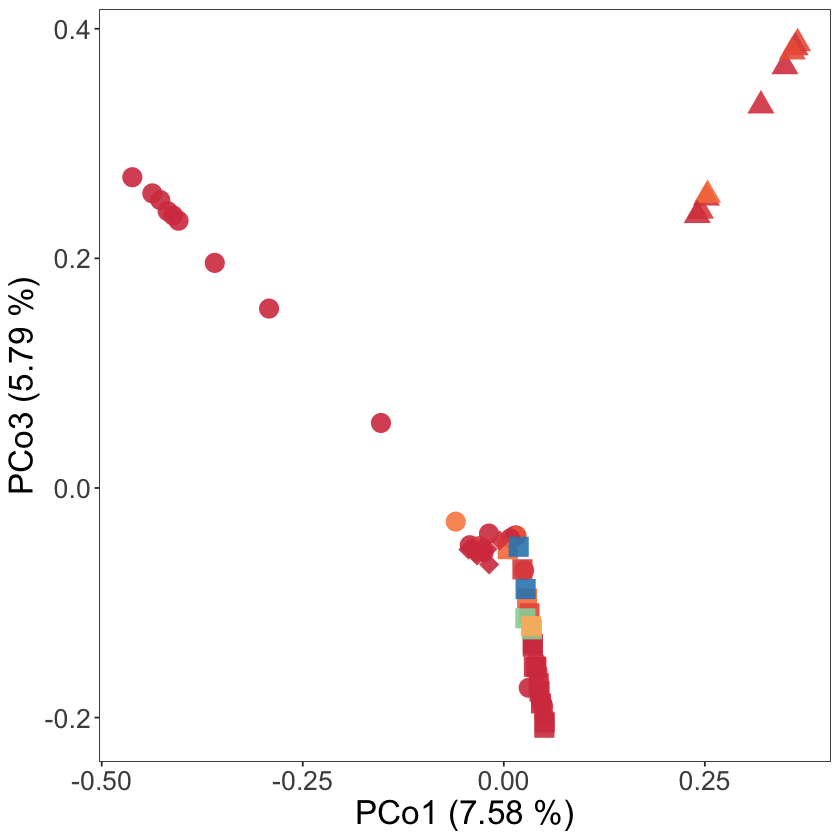

In [17]:
# Pcoa that is colored for continues metadata
# write to pdf
#pdf("../plots/220829_pcoa_virmoisture_ax13.pdf")

# set plot
p <- ggplot(axes, aes(Axis.1, Axis.2), width = 16, height = 12) 

# set color of the points as the factor depth, shape as year, set size and see-throughness
p + geom_point(aes(colour=Salts_mmho_cm1_1_S, shape=(plot)), size = 5,alpha=0.9, stroke=1) +
#p + geom_point(aes(colour=as.character(bulk_rhizo)), size = 6,alpha=0.9, stroke=1) +
 
  # set text for the axis lables
  xlab(paste("PCo1 (", eigval$Eigval[1], " %)", sep = "")) +  # or somthing else
  ylab(paste("PCo3 (", eigval$Eigval[3], " %)", sep = "")) +
  
  scale_colour_gradientn(colours=c(brewer.pal(8, "Spectral") )) +
  # dotted lines through the plot
  #geom_vline(xintercept = 0, linetype = 2) +
  #geom_hline(yintercept = 0, linetype = 2) +
  
  # set the colors of the points with the colorbrewer pallet
  #scale_color_brewer(name = "Time", palette = "Set1") +

  # you can set colors manually by this: 
  #scale_color_manual(name = 'soil', values = c("#377eb8", "#e41a1c", "yellow")) +

  # set shapes of the points
  scale_shape_manual(name = "Timepoint", values=c(16,17,15,18)) +

  # tell where the legend has to be
  guides(color = guide_legend(title.position = "top", title.hjust = 0.5)) +
  theme_bw() +
  
  # set text size for whole graph. set the background color (white with no lines)
  theme(text = element_text(size = 20), panel.grid.major = element_blank(),
  panel.grid.minor = element_blank(),
        legend.position = "None") 
dev.off()

## BioEnv Analysis
- https://rdrr.io/rforge/vegan/man/bioenv.html

In [ ]:
# Do bioenv analysis, save result in x
x <- bioenv(otu.dist, cat_meta.ordered, method = "spearman", index = "bray")

# print result
x